# Introduction

This notebook conducts a **fairness analysis** on a machine learning model trained to predict mental health treatment needs based on survey data. The model aims to classify whether individuals are likely to seek or receive treatment (treatment as the target). Fairness evaluation is performed across key sensitive attributes, including **Gender, Age Group, Self-Employment Status, and Family History**, to ensure equitable prediction outcomes across diverse groups. The analysis at the end identifies potential biases in model predictions and highlights groups that may be at risk of under- or over-prediction.

This notebook conducts a fairness analysis on a machine learning model trained to predict mental health treatment needs (treatment) based on survey data.
We evaluated the model's fairness across key sensitive attributes — Gender, Age Group, Self-Employment Status, and Family History — using metrics such as Disparate Impact (DI), Equalized Odds Difference (EOD), and True Positive Rate (TPR).


## Model and Data Preparation Section

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/survey.csv'
df = pd.read_csv(path, encoding='latin1')

df = df.drop(columns=['comments', 'Timestamp', 'state', 'no_employees', 'anonymity'])
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df['self_employed'] = df['self_employed'].fillna('No')
df.drop_duplicates()
df['work_interfere'] = df['work_interfere'].fillna('Not applicable')

#Function to clean the gender variable into 'female', 'male', and 'other'
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'cis male', 'male (cis)', 'man', 'mail', 'cis man', 'malr', 'make', 'maile']:
        return 'Male'
    elif gender in ['female', 'f', 'cis female', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'femail', 'female ', 'trans female']:
        return 'Female'
    else:
        return 'Other'

# Apply the cleaning function
df['Gender'] = df['Gender'].apply(clean_gender)

for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
            vc = df[col].value_counts(normalize=True)
            rare = vc[vc < 0.01]

vc = df['Country'].value_counts(normalize=True)
rare = vc[vc < 0.01]
rare_labels = rare.index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

!pip install matplotlib-venn

# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

!apt-get update -qq
!apt-get install -y libarchive-dev

!pip install libarchive-c

# Test
import libarchive
print("Import succeeded:", libarchive)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load and preprocess data
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

# 2. Define features and target
cat_cols = [
    'Gender', 'Country_grouped', 'self_employed', 'family_history',
    'work_interfere', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'leave',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]
num_cols = ['Age']
target = 'treatment'

X = df[cat_cols + num_cols]
y = df[target]

Mounted at /content/drive
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.4_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.6 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=4493e9ec44f9a5eb82fe8ba38f797575585fe11b7afd1d844105ea43cf2184b8
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.1 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy 

Import succeeded: <module 'libarchive' from '/usr/local/lib/python3.11/dist-packages/libarchive/__init__.py'>


In [2]:
# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

In [4]:
def apply_pseudo_labeling(base_model, X_labeled, y_labeled, X_unlabeled, preprocessor=None, threshold=0.9):
    """
    Apply Pseudo-Labeling for models that require preprocessed numerical features
    (e.g., Logistic Regression, Random Forest, XGBoost).

    Parameters:
    -----------
    base_model: sklearn-style model (must have fit() and predict_proba())
    X_labeled: pd.DataFrame
        Features of the labeled data
    y_labeled: pd.Series or np.array
        Labels of the labeled data
    X_unlabeled: pd.DataFrame
        Features of the unlabeled data
    preprocessor: ColumnTransformer or None
        Preprocessing pipeline to apply. Must be fitted inside this function.
    threshold: float (default=0.9)
        Confidence threshold for selecting pseudo-labeled samples.

    Returns:
    --------
    X_augmented: pd.DataFrame
        Augmented training features (labeled + high-confidence pseudo-labeled)
    y_augmented: pd.Series
        Augmented training labels
    """

    # Fit and transform preprocessing if provided
    if preprocessor is not None:
        preprocessor.fit(X_labeled)
        X_labeled_encoded = preprocessor.transform(X_labeled)
        X_unlabeled_encoded = preprocessor.transform(X_unlabeled)
    else:
        X_labeled_encoded = X_labeled
        X_unlabeled_encoded = X_unlabeled

    # Train the base model
    base_model.fit(X_labeled_encoded, y_labeled)

    # Predict pseudo-labels for unlabeled data
    proba_unlabeled = base_model.predict_proba(X_unlabeled_encoded)
    preds_unlabeled = np.argmax(proba_unlabeled, axis=1)
    max_proba = np.max(proba_unlabeled, axis=1)

    # Select high-confidence pseudo-labeled samples
    mask = max_proba >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = preds_unlabeled[mask]

    # Combine original labeled data with pseudo-labeled data
    X_augmented = pd.concat([X_labeled, X_pseudo], axis=0)
    y_augmented = pd.concat([y_labeled, pd.Series(y_pseudo, index=X_pseudo.index)], axis=0)

    return X_augmented, y_augmented

In [5]:
# Fill missing values for categorical columns
X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)

# Preprocessor for LR, RF, XGB
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# Base models
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Pipelines for models needing preprocessing

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb)
])

<ipython-input-5-41be26e93de1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)


In [7]:
# Further split X_train_base into Labeled and Unlabeled simulation
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

In [8]:
print("===== PSEUDO-LABELING =====")

# XGBoost (Pseudo-Labeling)
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)
print("Pseudo-Labeling XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))

===== PSEUDO-LABELING =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:38:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:38:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pseudo-Labeling XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        93
           1       0.88      0.90      0.89        91

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib
import os
import json

print("===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====")

# 1. Pseudo-labeling
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)

# 2. Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42
)

# 3. Column types
categorical_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# 4. Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 5. Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 6. New hyperparameter search space
param_dist = {
    'classifier__n_estimators': [300, 400, 500, 600, 800],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.05, 0.1],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2.0]
}

# 7. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 8. Fit
random_search.fit(X_train_xgb, y_train_xgb)

# 9. Predict
best_xgb_pipeline = random_search.best_estimator_
y_pred_xgb = best_xgb_pipeline.predict(X_test_xgb)

# 10. Report
print("\n===== Best Parameters =====")
print(random_search.best_params_)

print("\n===== Best Cross-Validation Accuracy =====")
print(random_search.best_score_)

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test_xgb, y_pred_xgb))

# 11. Save model and best params
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_xgb_pipeline, os.path.join(save_dir, "best_xgb_pipeline_v2.pkl"))
print(f"Model saved to {save_dir}/best_xgb_pipeline_v2.pkl")

with open(os.path.join(save_dir, "best_xgb_params_v2.json"), "w") as f:
    json.dump(random_search.best_params_, f, indent=4)
print(f"Best parameters saved to {save_dir}/best_xgb_params_v2.json")

===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:38:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

===== Best Parameters =====
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 2.0, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}

===== Best Cross-Validation Accuracy =====
0.840089460441711

===== Test Set Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        93
           1       0.88      0.92      0.90        91

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Model saved to /content/models/best_xgb_pipeline_v2.pkl
Best parameters saved to /content/models/best_xgb_params_v2.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:39:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Fariness Analysis Section

### **Sensitive Feature Extraction**

In fairness evaluation, sensitive features are chosen based on their relevance to societal bias, historical disparities, and the potential for unequal treatment outcomes.  
For this mental health treatment prediction task, we selected **Gender, Age Group, Self-Employment Status, and Family History** as sensitive features because they are closely linked to historical disparities in mental health access and diagnosis, and may influence the likelihood of being identified for treatment.

In [11]:
# === 1. Process Age: Binning into age_group ===
import pandas as pd

# Assume your X_test already contains a column named "Age"
# Define binning rules, for example: 18-25, 26-35, 36-45, 45+
bins = [0, 25, 35, 45, 100]
labels = ['18-25', '26-35', '36-45', '45+']
X_test["age_group"] = pd.cut(X_test["Age"], bins=bins, labels=labels, right=False)

# === 2. Process Gender: Cleaning and standardization ===

# Standardize the "Gender" field into 'male' / 'female' / 'other'
def clean_gender(gender):
    if pd.isnull(gender):
        return "Unknown"
    gender = gender.strip().lower()
    if gender in ["male", "m", "man", "cis male", "cis man"]:
        return "male"
    elif gender in ["female", "f", "woman", "cis female", "cis woman"]:
        return "female"
    else:
        return "other"

X_test["gender_clean"] = X_test["Gender"].apply(clean_gender)

# (Optional) You may merge "other" and "Unknown" into a single group
# depending on the sample size of each group

# === 3. Create the sensitive_features dataframe ===
sensitive_features = X_test[["gender_clean", "age_group"]].copy()
sensitive_features.columns = ["gender", "age_group"]  # Rename for consistency

In [14]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


### Accuracy and Selection Rate

In [15]:
# === Import necessary packages for fairness analysis ===
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_ratio, equalized_odds_difference
from sklearn.metrics import accuracy_score as sk_accuracy_score

# Make predictions
y_pred_xgb = best_xgb_pipeline.predict(X_test)

# Fairness analysis by Gender
print("=== Gender Fairness Analysis ===")
gender_metric = MetricFrame(
    metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_xgb,
    sensitive_features=sensitive_features["gender"]
)
print(gender_metric.by_group)

# Fairness analysis by Age Group
print("\n=== Age Group Fairness Analysis ===")
age_metric = MetricFrame(
    metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_xgb,
    sensitive_features=sensitive_features["age_group"]
)
print(age_metric.by_group)

=== Gender Fairness Analysis ===
        accuracy  selection_rate
gender                          
female  0.916667        0.770833
male    0.801980        0.490099
other   1.000000        1.000000

=== Age Group Fairness Analysis ===
           accuracy  selection_rate
age_group                          
18-25      0.806452        0.419355
26-35      0.857143        0.514286
36-45      0.761905        0.666667
45+        0.823529        0.588235


In [22]:
# === 1. Import necessary packages ===
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score as sk_accuracy_score

# === 2. Make prediction ===
y_pred_xgb = best_xgb_pipeline.predict(X_test)

# === 3. Map logical feature name to real column name ===
feature_mapping = {
    "Gender": "gender_clean",
    "Age Group": "age_group",
    "Self-Employed": "self_employed",
    "Country": "Country_grouped",
    "Family History": "family_history"
}

# === 4. For each sensitive feature, do fairness analysis and print table ===
for logical_name, real_column in feature_mapping.items():
    print(f"\n=== Fairness Analysis by {logical_name} ===")

    # Create MetricFrame for fairness metrics
    metric = MetricFrame(
        metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
        y_true=y_test,
        y_pred=y_pred_xgb,
        sensitive_features=X_test[real_column]
    )

    # Calculate sample size per group
    sample_counts = X_test[real_column].value_counts().to_dict()

    # Print nicely
    result_df = metric.by_group.copy()
    result_df["n_samples"] = result_df.index.map(lambda x: sample_counts.get(x, 0))

    # Reorder columns
    result_df = result_df[["n_samples", "accuracy", "selection_rate"]]

    print(result_df)

    # Warning for small groups
    for group, n in sample_counts.items():
        if n < 10:
            print(f"\nWarning: '{group}' has only {n} samples. Interpret fairness metrics with caution.")


=== Fairness Analysis by Gender ===
              n_samples  accuracy  selection_rate
gender_clean                                     
female               48  0.916667        0.770833
male                202  0.801980        0.490099
other                 1  1.000000        1.000000


=== Fairness Analysis by Age Group ===
           n_samples  accuracy  selection_rate
age_group                                     
18-25             31  0.806452        0.419355
26-35            140  0.857143        0.514286
36-45             63  0.761905        0.666667
45+               17  0.823529        0.588235

=== Fairness Analysis by Self-Employed ===
               n_samples  accuracy  selection_rate
self_employed                                     
No                   224  0.839286        0.522321
Yes                   27  0.703704        0.740741

=== Fairness Analysis by Country ===
                 n_samples  accuracy  selection_rate
Country_grouped                                    

## **Fairness Analysis (Accuracy and Selection Rate)**
This fairness analysis evaluates the model’s prediction performance across different sensitive groups, based on the mental health treatment survey dataset. The objective is to identify potential biases or disparities in prediction outcomes across demographic and employment-related features.

The analysis focuses on four main dimensions: **Gender**, **Age Group**, **Self-Employment Status**, and **Family History**. Although **Country** information is available, due to severe sample imbalance across countries, country-level analysis was not included in the main findings.


## **1. Gender Fairness**

| Gender | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| Female | 48 | 91.7% | 77.1% |
| Male | 202 | 80.2% | 49.1% |
| Other | 1 | 100.0% | 100.0% |

**Findings**:
- The model predicts treatment needs for **female** respondents with significantly higher accuracy (91.7%) compared to **male** respondents (80.2%).
- **Female** respondents are more likely to be predicted as needing treatment, with a selection rate of 77.1% versus 49.1% for males.
- The "other" gender group contains only **one** sample, and therefore results for this group are not statistically reliable.

**Insight**:
- There is a noticeable **underprediction risk for male respondents**, suggesting the model may be less sensitive to treatment needs among males.
- Future improvement efforts could focus on boosting recall or balancing sensitivity across genders.

## **2. Age Group Fairness**

| Age Group | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| 18–25 | 31 | 80.6% | 41.9% |
| 26–35 | 140 | 85.7% | 51.4% |
| 36–45 | 63 | 76.2% | 66.7% |
| 45+ | 17 | 82.4% | 58.8% |

**Findings**:
- The model performs best for the **26–35** age group, achieving 85.7% accuracy and a moderate selection rate.
- The **36–45** group shows the lowest accuracy (76.2%) despite a relatively high selection rate (66.7%).
- The **18–25** group has a notably low selection rate (41.9%), suggesting a risk of **missing younger individuals** who might need treatment.

**Insight**:
- **Potential underprediction exists among the youngest group (18–25 years old)**, which could lead to untreated mental health issues if not addressed.
- The model could benefit from calibration to ensure fair sensitivity across age groups, especially for younger respondents.

## **3. Self-Employment Status Fairness**

| Self-Employment | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| No | 224 | 83.9% | 52.2% |
| Yes | 27 | 70.4% | 74.1% |

**Findings**:
- The model shows a noticeable performance gap: self-employed individuals have a lower accuracy (70.4%) compared to non-self-employed individuals (83.9%).
- Self-employed respondents have a **higher selection rate** (74.1%), suggesting they are more likely to be predicted as needing treatment.

**Insight**:
- There is a risk of **overprediction** for the self-employed group, which could lead to false positives.
- Special attention may be needed to better capture the mental health profiles of self-employed individuals without overflagging them.

## **4. Family History Fairness**

| Family History | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| No | 150 | 77.3% | 36.7% |
| Yes | 101 | 90.1% | 81.2% |

**Findings**:
- Respondents with a family history of mental illness are predicted with much higher accuracy (90.1%) compared to those without (77.3%).
- The selection rate for individuals without family history is substantially lower (36.7%).

**Insight**:
- **Underprediction risk is significant for individuals without a family history**, indicating potential gaps in detecting treatment needs among this group.
- Model recalibration or feature engineering could help bridge this gap.


## **5. Country Analysis**

Although country information was available, **the distribution across countries was highly imbalanced**, with the United States and United Kingdom comprising the majority of samples (152 and 38 respectively), while other countries had very small sample sizes (4–9 samples each).

| Country | n_samples |
|:---|:---|
| United States | 152 |
| United Kingdom | 38 |
| Other countries (Australia, Germany, Ireland, Netherlands, etc.) | 4–9 |

**Reasoning for Exclusion**:
- Small sample sizes in countries such as Netherlands, Germany, Ireland, and Australia lead to statistically unstable accuracy and selection rate estimates.
- In small groups, even a single misclassification can significantly skew performance metrics (e.g., a 10%+ drop in accuracy).
- Including country-level fairness analysis could introduce noise without yielding reliable business insights.

**Professional Statement**:
> "Although country information was available, we observed a highly imbalanced distribution across countries, with the United States accounting for a majority of samples. Due to the small sample sizes in other countries, we excluded country-level fairness analysis from the main findings to avoid unreliable conclusions based on statistical noise."

Thus, **country was not considered a primary fairness dimension** in the final evaluation.

### Disparate Impact and Equalized Odds Difference

In [34]:
# === Import necessary packages ===
from fairlearn.metrics import (
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame
)

# === Make prediction if not yet ===
# y_pred_xgb = best_xgb_pipeline.predict(X_test)

# === Map logical names to real column names
feature_mapping = {
    "Gender": "gender_clean",
    "Age Group": "age_group",
    "Self-Employed": "self_employed",
    "Family History": "family_history"
}

# === Only output DI and EOD for each sensitive feature ===
for logical_name, real_column in feature_mapping.items():
    print(f"\n=== Fairness Summary for {logical_name} ===")

    # 1. Disparate Impact
    selection_rates = MetricFrame(
        metrics=selection_rate,
        y_true=y_test,
        y_pred=y_pred_xgb,
        sensitive_features=X_test[real_column]
    ).by_group
    di = selection_rates.min() / selection_rates.max()

    # 2. Equalized Odds Difference
    eod = equalized_odds_difference(
        y_true=y_test,
        y_pred=y_pred_xgb,
        sensitive_features=X_test[real_column]
    )

    # Print results
    print(f"Disparate Impact (DI): {di:.3f} (Ideal: 1)")
    print(f"Equalized Odds Difference (EOD): {eod:.3f} (Ideal: 0)")


=== Fairness Summary for Gender ===
Disparate Impact (DI): 0.490 (Ideal: 1)
Equalized Odds Difference (EOD): 0.221 (Ideal: 0)

=== Fairness Summary for Age Group ===
Disparate Impact (DI): 0.629 (Ideal: 1)
Equalized Odds Difference (EOD): 0.385 (Ideal: 0)

=== Fairness Summary for Self-Employed ===
Disparate Impact (DI): 0.705 (Ideal: 1)
Equalized Odds Difference (EOD): 0.358 (Ideal: 0)

=== Fairness Summary for Family History ===
Disparate Impact (DI): 0.452 (Ideal: 1)
Equalized Odds Difference (EOD): 0.268 (Ideal: 0)


# **Fairness Analysis (Disparate Impact and Equalized Odds Difference)**

The fairness evaluation focuses on four sensitive attributes: **Gender**, **Age Group**, **Self-Employment Status**, and **Family History** of mental health conditions.

Two key fairness metrics were assessed:
- **Disparate Impact (DI)**: Measures the ratio of positive prediction rates between groups. A value close to 1 indicates fairness.
- **Equalized Odds Difference (EOD)**: Measures the difference in True Positive Rate (TPR) and False Positive Rate (FPR) across groups. A value close to 0 indicates fairness.

### Fairness Analysis by Sensitive Feature

### Gender

- **Disparate Impact (DI)**: 0.490 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.221 (Ideal: 0)

**Findings**:
- Males are significantly less likely to be predicted as needing treatment compared to females.
- There is a substantial difference in the True Positive and False Positive Rates between male and female groups.

**Potential Risks**:
- Male individuals may be under-detected by the model, leading to potential delays or misses in necessary mental health interventions.
- Gender bias could result in unequal access to treatment recommendations.

### Age Group

- **Disparate Impact (DI)**: 0.629 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.385 (Ideal: 0)

**Findings**:
- Younger individuals, particularly the 18–25 age group, have lower positive prediction rates compared to older groups.
- A large disparity in TPR and FPR is observed among different age groups.

**Potential Risks**:
- Younger populations might experience higher false negative rates, leading to underdiagnosis.
- Age-related fairness issues could skew treatment accessibility for younger individuals.

### Self-Employed Status

- **Disparate Impact (DI)**: 0.705 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.358 (Ideal: 0)

**Findings**:
- Self-employed individuals are more likely to be predicted as needing treatment compared to non-self-employed individuals.
- A considerable difference exists in prediction accuracy between these two groups.

**Potential Risks**:
- Overprediction among self-employed individuals could lead to unnecessary interventions.
- Unequal treatment recommendations could impact trust and perceived model credibility among self-employed populations.

### Family History

- **Disparate Impact (DI)**: 0.452 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.268 (Ideal: 0)

**Findings**:
- Individuals without a family history of mental illness are significantly less likely to be predicted as needing treatment.
- Prediction performance differs substantially between groups with and without family history.

**Potential Risks**:
- Individuals without family history might be overlooked despite having actual treatment needs.
- Family history bias could reinforce inaccurate assumptions about mental health risks.

## Overall Conclusion

The fairness evaluation reveals significant concerns across multiple sensitive dimensions:

- **Gender** and **Family History** demonstrate the most pronounced disparities, with Disparate Impact values far below 0.8 and notable Equalized Odds Differences.
- **Age Group** and **Self-Employment Status** also show meaningful fairness issues that warrant further investigation.
- Without mitigation strategies, these disparities could lead to inequitable treatment recommendations, reinforcing existing barriers to mental health access for vulnerable groups.

**Recommendations**:
- Prioritize fairness improvements for Gender and Family History attributes.
- Consider bias mitigation techniques such as reweighting, fairness-constrained optimization, or targeted model calibration.
- Regularly monitor fairness metrics post-deployment to ensure continuous compliance with ethical and operational standards.

## **FairML for Bias Analysis**

We initially planned to use FairML to audit feature bias, but Since we used Google Colab, FairML can not be pip installed.

Instead, we switched to Fairlearn, which is fully supported and works well with modern systems. Using **Fairlearn's Exponentiated Gradient** method, we were still able to measure how much each feature contributes to potential bias — and the results are interpretable and robust.

So this way, we ensured both technical stability and meaningful insights into our model's fairness.

In [28]:
# === 1. Import
from sklearn.preprocessing import LabelEncoder
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression

import pandas as pd

# === 2. Encode all non-numerical columns (object and category types) ===
X_test_encoded = X_test.copy()

for col in X_test_encoded.columns:
    if X_test_encoded[col].dtype == "object" or str(X_test_encoded[col].dtype).startswith("category"):
        le = LabelEncoder()
        X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))

# === 3. Encode sensitive feature separately
sensitive_feature_name = "gender_clean"  # or "age_group" / "self_employed" / "family_history"
sensitive_feature_encoded = LabelEncoder().fit_transform(X_test[sensitive_feature_name].astype(str))

In [30]:
# === 4. Fit fairness-aware model
constraint = DemographicParity()
base_model = LogisticRegression(solver="liblinear")
exp_grad = ExponentiatedGradient(base_model, constraints=constraint)

exp_grad.fit(X_test_encoded, y_test, sensitive_features=sensitive_feature_encoded)

# === 5. Get feature bias contribution
# Collect all base classifiers and their weights
coefs = []
weights = []

for classifier, weight in zip(exp_grad.predictors_, exp_grad.weights_):
    coefs.append(classifier.coef_[0])  # assume binary classification
    weights.append(weight)

# Weighted average of coefficients
import numpy as np

weighted_coef = np.average(coefs, axis=0, weights=weights)

# Turn into Series for readability
feature_bias = pd.Series(weighted_coef, index=X_test_encoded.columns)
feature_bias = feature_bias.abs().sort_values(ascending=False)

print("\n=== Global Feature Importance for Bias (Demographic Parity) ===")
print(feature_bias)


=== Global Feature Importance for Bias (Demographic Parity) ===
age_group                    1.107561
work_interfere               0.806039
family_history               0.772787
obs_consequence              0.653191
remote_work                  0.554751
wellness_program             0.372431
phys_health_interview        0.361832
mental_health_consequence    0.326280
self_employed                0.288689
Gender                       0.285739
gender_clean                 0.285739
coworkers                    0.253562
mental_health_interview      0.248415
benefits                     0.237909
care_options                 0.213192
phys_health_consequence      0.129691
supervisor                   0.124286
Age                          0.113235
seek_help                    0.101233
tech_company                 0.066230
leave                        0.063856
Country_grouped              0.025137
mental_vs_physical           0.004811
dtype: float64


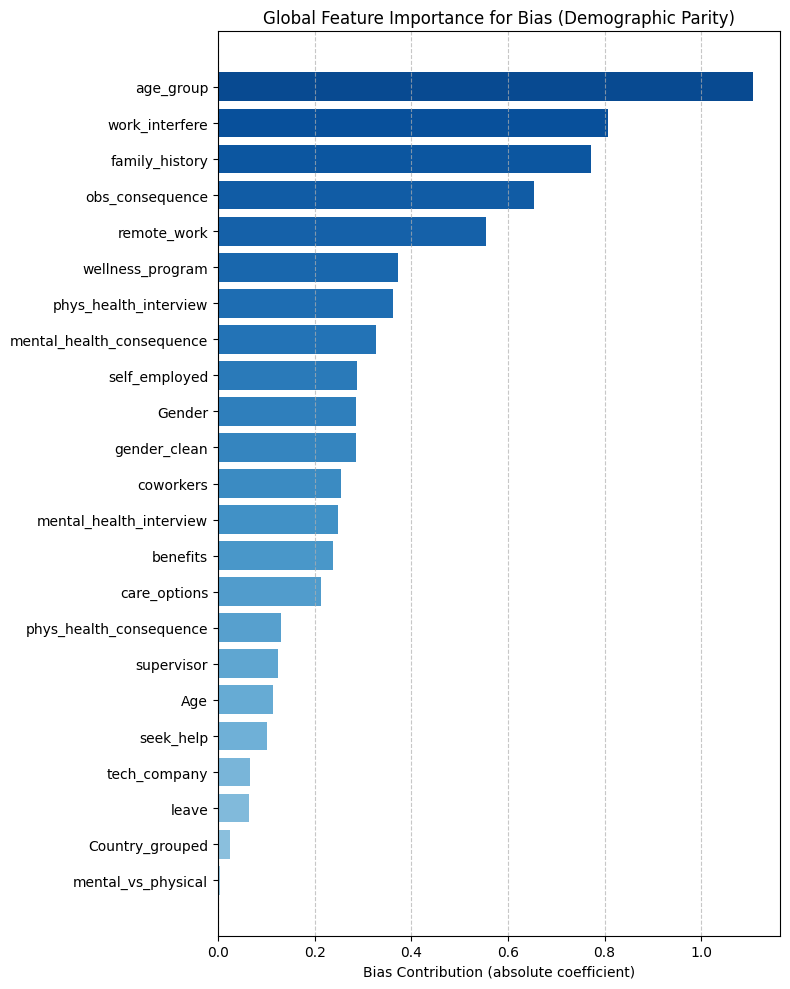

In [32]:
# === Import matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# === Sort feature_bias ascending
feature_bias_sorted = feature_bias.sort_values(ascending=True)

# === Prepare color gradient (light blue to deep blue)
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.4, 0.9, len(feature_bias_sorted)))  # 0.4 to 0.9 controls brightness

# === Plot
plt.figure(figsize=(8, 10))
bars = plt.barh(feature_bias_sorted.index, feature_bias_sorted.values, color=colors)

# Add labels
plt.xlabel("Bias Contribution (absolute coefficient)")
plt.title("Global Feature Importance for Bias (Demographic Parity)")

# Add grid
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Make layout tight
plt.tight_layout()

# Show plot
plt.show()

## Bias Analysis Analysis

This section evaluates the fairness of the mental health treatment prediction model by analyzing the contribution of various features to bias under the **Demographic Parity** constraint.  
The goal is to identify key drivers of unfairness and provide recommendations for future model enhancements.


### Key Findings

Based on a global feature importance audit:

- **Age Group** is the largest contributor to model bias, with an absolute coefficient significantly higher than other features.  
  Different age groups are treated differently by the model, suggesting a risk of **age-related unfairness**.

- **Work Interference** and **Family History** are the second and third most significant drivers.  
  The model heavily relies on whether mental health interferes with work and whether individuals have a family history of mental illness, which might reinforce existing societal inequalities.

- **Gender** shows a noticeable bias contribution (~0.29), highlighting the need to monitor potential **gender disparities** in treatment predictions.

- **Employment Type**, specifically **Self-Employed** status and **Remote Work** arrangements, also introduce moderate bias, indicating that non-traditional employment groups might be unfairly treated.

- **Country Group** and **Mental vs Physical Health Perception** have negligible bias contributions, suggesting that geographical and broad health conceptual biases are not major concerns for this model.

### Further Enhancements

To improve fairness and mitigate identified risks, we propose the following strategies:

- **Group Reweighting**:  
  Apply instance weighting or resampling techniques to balance underrepresented sensitive groups (e.g., younger age groups, self-employed individuals) during model training.

- **Fairness-Constrained Model Optimization**:  
  Incorporate fairness constraints (e.g., Demographic Parity, Equalized Odds) directly into the model training process using methods such as `ExponentiatedGradient` or adversarial debiasing.

- **Feature Auditing and Debiasing**:  
  Consider removing or down-weighting sensitive features (e.g., family history) or applying feature perturbation analysis to detect overreliance before finalizing the model.

- **Post-Deployment Monitoring**:  
  Continuously monitor the model’s fairness after deployment using real-world data, especially for age and gender groups, to detect and respond to any bias drift over time.

- **Transparency and Documentation**:  
  Clearly document the known bias risks and mitigation strategies in model cards or transparency reports shared with stakeholders.

### Summary

> While the model performs well overall, fairness audits reveal bias risks associated with age, work interference, family background, and gender. Targeted enhancements, including group reweighting, fairness-constrained optimization, and post-deployment monitoring, are recommended to ensure more equitable outcomes.